<a href="https://colab.research.google.com/github/elifsare/Real-time-Emotion-Recognition/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
!ls

Mounted at /content/drive
drive  sample_data


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d msambare/fer2013

In [ ]:
!mkdir face_dataset
!unzip '/content/fer2013.zip' -d face_dataset

In [5]:
import pandas as pd                       
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 

from keras.models import Sequential     
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, AveragePooling2D, Activation
from keras.optimizers import SGD, Adam, RMSprop, Adamax 
from keras.utils import np_utils  
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.utils import load_img, img_to_array

import os
import seaborn as sns
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers

In [6]:
train_path = '/content/face_dataset/train'
test_path = '/content/face_dataset/test'

In [7]:
img_size = 48

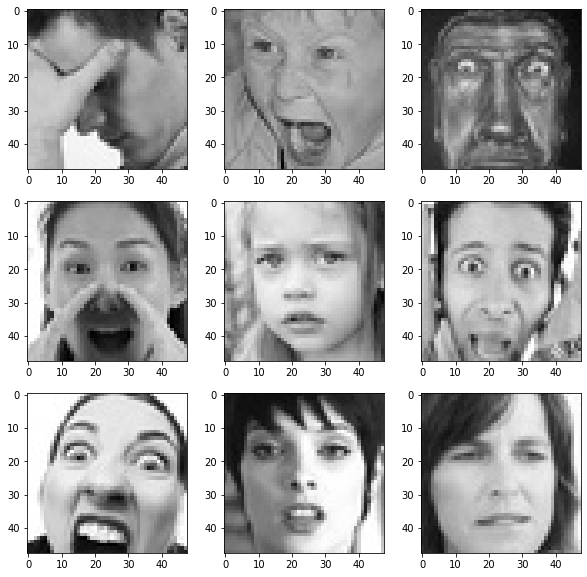

In [8]:
expression = 'fear'
plt.figure(figsize= (10,10))
folder_path = '/content/face_dataset/'
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(train_path + '/' + expression + "/" + os.listdir(train_path  + '/' + expression)[i], 
                   target_size=(48, 48)
                   )
    plt.imshow(img)   
plt.show()

In [9]:
train_generator = ImageDataGenerator(width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    rescale = 1./255,
                                    validation_split = 0.2
                                    )
validation_generator = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [10]:
train_flow = train_generator.flow_from_directory(directory = train_path,
                                                target_size = (img_size,img_size),
                                                batch_size = 64,
                                                color_mode = "grayscale",
                                                class_mode = "categorical",
                                                subset = "training"
                                                )
validation_flow = validation_generator.flow_from_directory( directory = test_path,
                                                            target_size = (img_size,img_size),
                                                            batch_size = 64,
                                                            color_mode = "grayscale",
                                                            class_mode = "categorical",
                                                            subset = "validation"
                                                            )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [11]:
#num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten()) 

model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(7, activation='softmax'))

model.summary()

model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
# CheckPoint
root = '/content/drive/MyDrive/DeepLearningProject/EmotionDetection/'
checkPointer = ModelCheckpoint(root + 'checkPoint_model.h5', verbose = 1, save_best_only = True)

In [13]:
# overfitting engelliyoruz
# EarlyStop
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=7,
                               verbose=1,
                               restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=5,
                                        verbose=1,
                                        min_delta=0.0001)

callbacks_list = [early_stopping, checkPointer, reduce_learningrate]

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [14]:
epochs = 100
batch_size = 64

In [15]:
history = model.fit(x = train_flow,
                    epochs = epochs,
                    validation_data = validation_flow,
                    callbacks= callbacks_list)

Epoch 1/100
359/359 [==============================] - ETA: 0s - loss: 4.8251 - accuracy: 0.2328
Epoch 1: val_loss improved from inf to 2.64335, saving model to /content/drive/MyDrive/DeepLearningProject/EmotionDetection/checkPoint_model.h5
359/359 [==============================] - 36s 73ms/step - loss: 4.8251 - accuracy: 0.2328 - val_loss: 2.6434 - val_accuracy: 0.2235 - lr: 0.0010
Epoch 2/100
359/359 [==============================] - ETA: 0s - loss: 2.2585 - accuracy: 0.3451
Epoch 2: val_loss improved from 2.64335 to 2.62029, saving model to /content/drive/MyDrive/DeepLearningProject/EmotionDetection/checkPoint_model.h5
359/359 [==============================] - 23s 64ms/step - loss: 2.2585 - accuracy: 0.3451 - val_loss: 2.6203 - val_accuracy: 0.2144 - lr: 0.0010
Epoch 3/100
359/359 [==============================] - ETA: 0s - loss: 2.2189 - accuracy: 0.4340
Epoch 3: val_loss improved from 2.62029 to 2.22898, saving model to /content/drive/MyDrive/DeepLearningProject/EmotionDetecti

In [16]:
train_loss, train_acc = model.evaluate(train_flow)
test_loss, test_acc   = model.evaluate(validation_flow)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc * 100, test_acc * 100))

23/23 [==============================] - 1s 25ms/step - loss: 1.0335 - accuracy: 0.6934
final train accuracy = 74.67 , validation accuracy = 69.34


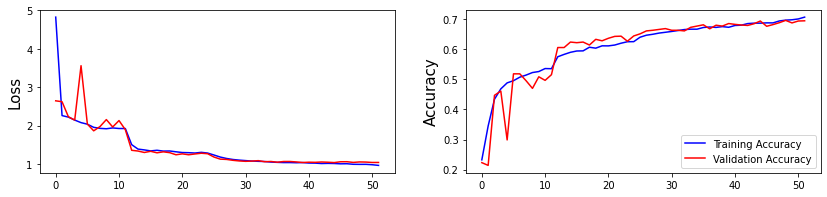

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize = (14,3))
plt.subplot(1,2,1)
#plt.suptitle('Train', fonstsize = 10)
plt.ylabel('Loss', fontsize = 15)
plt.plot(history.history['loss'], color = 'b', label = 'Training Loss')
plt.plot(history.history['val_loss'], color = 'r', label = 'Validation Loss')

plt.subplot(1,2,2)
plt.ylabel('Accuracy', fontsize = 15)
plt.plot(history.history['accuracy'], color = 'b', label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], color = 'r', label = 'Validation Accuracy')

plt.legend(loc = 'lower right')

plt.show()

In [18]:
model.save('/content/drive/MyDrive/DeepLearningProject/EmotionDetection/model.h5')